## Importing the libraries

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import pickle

## Load and preprocess the MRI images

In [13]:
# Define paths for the different types of images
paths = {
    'type_1': '/Users/nadunsenarathne/Downloads/Documents/Nadun/space odyssey /Space_Odyssey/datathon/Datathon-Dataset/category1_tumor',
    'type_2': '/Users/nadunsenarathne/Downloads/Documents/Nadun/space odyssey /Space_Odyssey/datathon/Datathon-Dataset/category2_tumor',
    'type_3': '/Users/nadunsenarathne/Downloads/Documents/Nadun/space odyssey /Space_Odyssey/datathon/Datathon-Dataset/category3_tumor',
    'no_tumor': '/Users/nadunsenarathne/Downloads/Documents/Nadun/space odyssey /Space_Odyssey/datathon/Datathon-Dataset/no_tumor'
}

# Load and preprocess the MRI images
data = []
labels = []

for label, path in paths.items():
    for image_name in os.listdir(path):
        image_path = os.path.join(path, image_name)
        image = load_img(image_path, target_size=(150, 150, 3))
        image_array = img_to_array(image)
        data.append(image_array)
        labels.append(label)

data = np.array(data) / 255.0  # Normalize
labels = np.array(labels)

## Visualization of some sample images

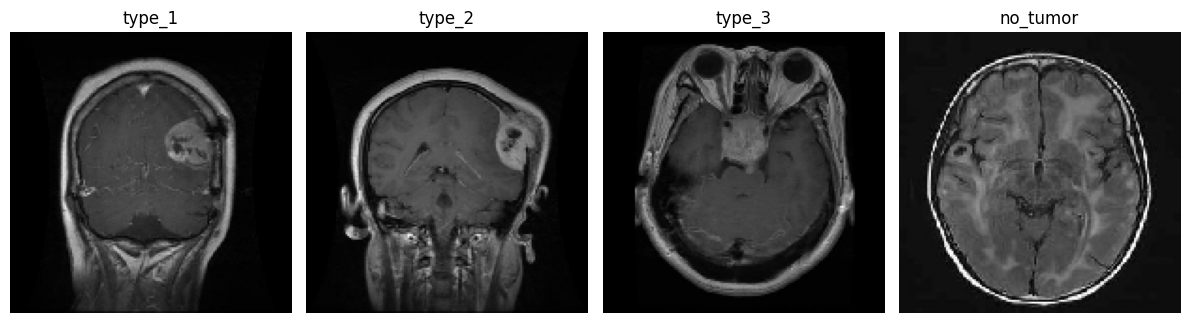

In [14]:
plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(1, 4, i+1)
    sample_image = data[np.where(labels == list(paths.keys())[i])[0][0]]
    plt.imshow(sample_image)
    plt.title(list(paths.keys())[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Deep Neural Network architecture using 3D Convolutional layers

In [15]:
model = Sequential()

model.add(Input(shape=(150, 150, 3, 1)))  # 3D input

model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 150, 150, 3, 32)   896       
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 75, 2, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 75, 2, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 38, 38, 1, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 38, 38, 1, 128)    221312    
                                                                 
 flatten (Flatten)           (None, 184832)            0

## Splitting the dataset and training the model

In [16]:
# Convert labels to one-hot encoding
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Reshape the data for 3D convolution
X_train = X_train.reshape(X_train.shape[0], 150, 150, 3, 1)
X_test = X_test.reshape(X_test.shape[0], 150, 150, 3, 1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)

# Early stopping & checkpointing the best model
early_stopping = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath="best_model.pkl", save_best_only=True, verbose=1)


Epoch 1/15
81/81 [==============================] - 329s 4s/step - loss: 1.1155 - accuracy: 0.5250 - val_loss: 0.9190 - val_accuracy: 0.5953
Epoch 2/15
81/81 [==============================] - 328s 4s/step - loss: 0.7295 - accuracy: 0.7018 - val_loss: 0.7453 - val_accuracy: 0.7008
Epoch 3/15
81/81 [==============================] - 323s 4s/step - loss: 0.5299 - accuracy: 0.7953 - val_loss: 0.5740 - val_accuracy: 0.7659
Epoch 4/15
81/81 [==============================] - 334s 4s/step - loss: 0.3760 - accuracy: 0.8577 - val_loss: 0.5326 - val_accuracy: 0.8233
Epoch 5/15
81/81 [==============================] - 335s 4s/step - loss: 0.2531 - accuracy: 0.9050 - val_loss: 0.5520 - val_accuracy: 0.8434
Epoch 6/15
81/81 [==============================] - 318s 4s/step - loss: 0.1620 - accuracy: 0.9434 - val_loss: 0.5267 - val_accuracy: 0.8682
Epoch 7/15
81/81 [==============================] - 331s 4s/step - loss: 0.1327 - accuracy: 0.9554 - val_loss: 0.4284 - val_accuracy: 0.8837
Epoch 8/15
81

## Plotting training & validation accuracy values

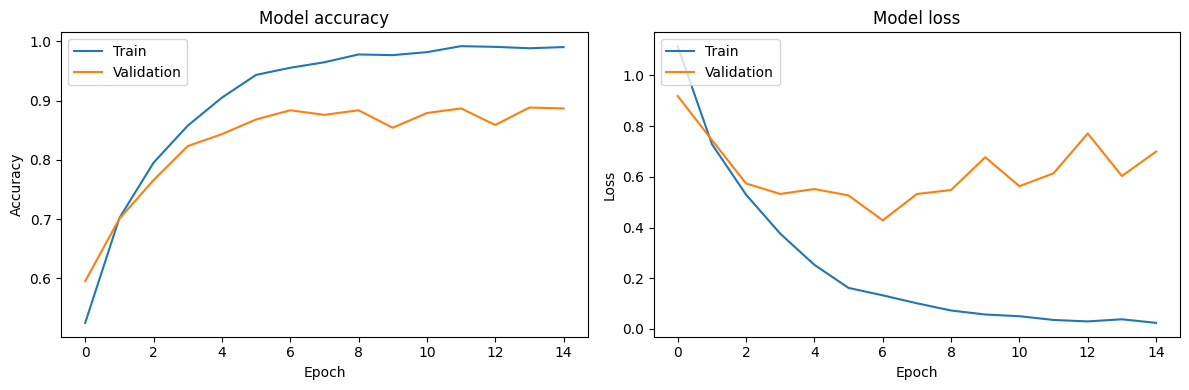

In [17]:
plt.figure(figsize=(12, 4))

# model acccuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# model loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Model Evaluation

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

21/21 [==============================] - 9s 446ms/step - loss: 0.6997 - accuracy: 0.8868
Test Accuracy: 88.68%


## Saving the model to a pickle file

In [19]:
pickle.dump(model, open('Brain_Tumor_Detection_Model.pkl', 'wb'))